# **Trabalho Prático 1 - Geometria Computacional**


### **Universidade Federal de Minas Gerais - Instituto de Ciências Exatas**

#### Departamento de Ciência da Computação

DCC207 - Algoritmos 2

Prof. Renato Vimieiro


  
**Alunos:** Daniel Barbosa, Frederico Baker e Victor Prates

O presente trabalho visa a aplicação de algoritmos de geometria computacional para solucionar um problema de classificação em aprendizado de máquina supervisionado. Em especial, o problema de classificação a ser abordado se refere à triagem de pacientes em um serviço de saúde. A meta é criar um modelo de classificação usando técnicas como envoltória convexa e detecção de interseções entre segmentos.

No diretório ./models foram implementadas estruturas para representar pontos e segmentos, além das seguintes operações:
* Determinar a orientação relativa de dois segmentos
* Determinar se um ponto está sobre um segmento
* Determinar se dois segmentos se interceptam

In [1]:
from models.models import Point
from models.models import Segment

# 1. Envoltória convexa

Uma envoltória convexa é o menor polígono convexo que contém todo um conjunto de pontos P. Existem diversos algoritmos que podem ser usados para encontrar a envoltória convexa de um conjunto de pontos. A escolha do algoritmo para encontrar a envoltória convexa em dados reais depende de várias circunstâncias, principalmente das características dos dados e do caso de uso específico. Vamos considerar aqui dois algoritmos, o Graham Scan e o Gift Wrapping:

1. **Graham Scan:** Possui complexidade O(n lg n) no melhor e pior caso, sevido à etapa de ordenação dos pontos.

2. **Gift Wrapping:** Complexidade O(nh), onde h é o número de pontos da envoltória convexa. No pior caso, quando todos os pontos pertencem a envoltória, h = n, tornando a complexidade em O(n^2)

Para que o gift wrapping se degenere para o seu pior caso, os pontos precisam estar distribuídos no plano de uma maneira extremamente precisa, se aproximando cada vez mais de um círculo a medida que o número de pontos aumenta. Esse cenário é dificilmente observado em dados reais, como é o caso aqui. Em contraste, usualmente, dados reais apresentam outliers e certa dispersão dos pontos, indicando que o número de vértices na envoltória não será tão grande. Logo, espera-se que o Gift Wrapping apresente melhor desempenho do que o Graham Scan, uma vez que em dados reais é possivel que a complexidade dele se aproxime mais do seu melhor caso O(n).

In [2]:
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm

## 1.1 Funções auxiliares

Inicialmente, será implementada uma função que identifica se há uma mudança de direção para a esquerda ao seguir o caminho A -> B -> C.

In [3]:
# Returns True if a left turn happens in the path A -> B -> C
def leftTurn(pointA, pointB, pointC):
    segmentAB = Segment(pointA, pointB)
    direction = segmentAB.direction(pointC)

    if direction > 0:
        return True
    
    return False

Uma otimização possível para qualquer algoritmo de envoltória é determinar os quatro pontos nos extremos do conjunto (menor x, maior x, menor y e maior y) e excluir todos os pontos que estão dentro do quadrilátero formado por eles. Abaixo está a prova de que isso não afeta o resultado final:

**Prova:** Suponha que um dos pontos internos ao quadrilátero fizesse parte da envoltória. Como esse ponto está dentro do quadrilátero pelo menos um dos pontos extremos estaria fora da envoltória que ele pertence, assim esse ponto não pode pertencer à envoltória, o que contraria a suposição inicial. Logo nenhum dos pontos internos a esse quadrilátero, formado pelos pontos extremos, faz parte da envoltória.

In [4]:
def deleteIntermediatePoints(points):
    bottomMost = points[0]
    rightMost = points[0]
    topMost = points[0]
    leftMost = points[0]

    for i in range(1, len(points)):
        # Checks bottom-most
        if points[i].y < bottomMost.y:
            bottomMost = points[i]

        # Checks right-most
        if points[i].x > rightMost.x:
            rightMost = points[i]

        # Checks top-most
        if points[i].y > topMost.y:
            topMost = points[i]

        # Checks left-most
        if points[i].x < leftMost.x:
            leftMost = points[i]

    segments = []
    segments.append(Segment(bottomMost, rightMost))
    segments.append(Segment(rightMost, topMost))
    segments.append(Segment(topMost, leftMost))
    segments.append(Segment(leftMost, bottomMost))

    pointsOutside = []
    for point in points:

        # If all four segments are clockwise in relation to a point, this is a 
        # inner point. This is true because segments are counter clockwise 
        # ordered.
        rightOrientation = False
        for segment in segments:
            if segment.direction(point) <= 0:
                rightOrientation = True
                break
        
        # If at least one segment is not clockwise -> Point is outside
        if rightOrientation:
            pointsOutside.append(point)
            continue

    return pointsOutside

## 1.2 Implementação do Gift Wrapping

In [5]:
def giftWrapping(points):

    # For less than 3 points the answer is trivial
    if len(points) <= 3:
        return points
    
    points = deleteIntermediatePoints(points)
    
    # Finds the index of the pivot -> Minimum y-coordinate or the leftmost in case of a tie
    pivotIdx = 0
    for i in range(1, len(points)):
        if points[i].y < points[pivotIdx].y:
            pivotIdx = i
        elif points[i].y == points[pivotIdx].y and points[i].x < points[pivotIdx].x:
            pivotIdx = i

    pivot = points[pivotIdx]

    # Hull starts with the pivot
    hull = []
    hull.append(pivot)

    n = len(points)
    curHullCandidateIdx = (pivotIdx + 1) % n
    while True:
        
        # If there exists a point i such that the path passing through the last 
        # point of the hull, through i, and then through the current candidate 
        # makes a left turn, it means that the current candidate is not part of 
        # the hull and i becomes the current candidate.
        for i in range(0, len(points)):
            if leftTurn(hull[-1], points[i], points[curHullCandidateIdx]):
                curHullCandidateIdx = i
                
        # If the pivot is found again, the hull is complete.
        if curHullCandidateIdx == pivotIdx:
            break
        
        hull.append(points[curHullCandidateIdx])

        # Update the index to the next possible candidate.
        curHullCandidateIdx = (curHullCandidateIdx + 1) % n

    return hull     


## 1.3 Testes

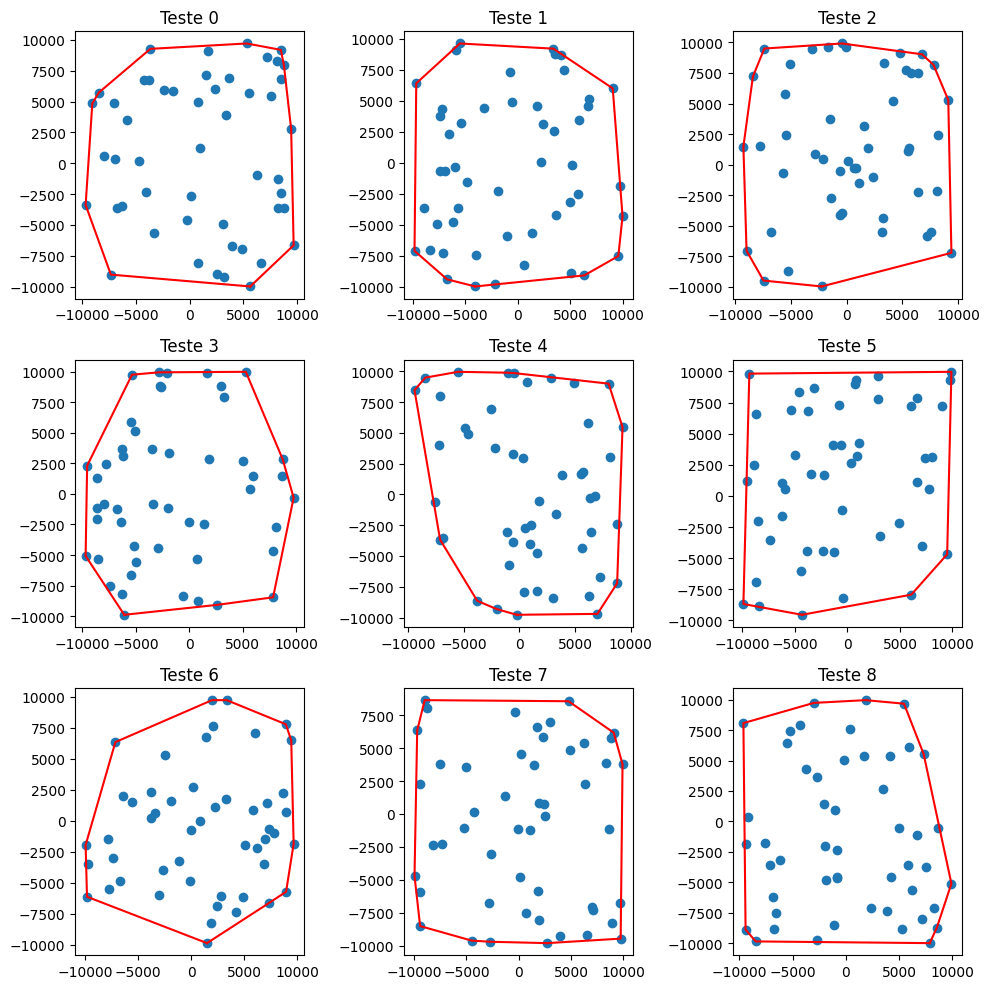

In [6]:
# Create random points in a range
def createPoints(numPoints, min = 0, max = 50):
    return [Point(randint(min, max), randint(min, max)) for _ in range(numPoints)] 

# Plot the hull and points
def scatterPlot(points, hull):
    xCoords = [point.x for point in points]
    yCoords = [point.y for point in points]

    hullXCoords = [point.x for point in hull]
    hullYCoords = [point.y for point in hull]

    hullXCoords.append(hull[0].x)
    hullYCoords.append(hull[0].y)
    
    plt.scatter(xCoords, yCoords)

    # Plot the segments of the convex hull
    plt.plot(hullXCoords, hullYCoords, 'r')

    plt.title("Example")

    plt.show()

# Create a 3x3 grid of plots
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        points = createPoints(50, -10000, 10000)
        hull = giftWrapping(points)

        xCoords = [point.x for point in points]
        yCoords = [point.y for point in points]

        hullXCoords = [point.x for point in hull]
        hullYCoords = [point.y for point in hull]

        hullXCoords.append(hull[0].x)
        hullYCoords.append(hull[0].y)
        
        axs[i, j].scatter(xCoords, yCoords)
        axs[i, j].plot(hullXCoords, hullYCoords, 'r')
        axs[i, j].set_title(f'Teste {3*i+j}')

plt.tight_layout()
plt.show()

# 2. Varredura linear

Aqui, vamos implementar um algoritmo que verifica se algum segmento de uma envoltória A intercepta algum segmento de uma envoltória B.

Se há pelo o menos uma interceptação (ou seja, os dados não são linearmente separáveis), o algoritmo deve retornar verdadeiro

Se não há interceptação (ou seja, os dados são linearmente separáveis), o algoritmo deve retornar o falso.

Primeiro, vamos tratar de um caso específico:

- Todos os segmentos de uma envoltória convexa se intersectam. Por isso, o algoritmo que impementaremos desconsiderará interseções que ocorrem exatamente na extremidade de um segmento com a extremidade de outro segmento.
    
- Isso não atrapalhará na separabilidade das envoltórias, pois, se uma extremidade de envoltória intercepta uma extremidade da outra envoltória, essa extremidade em comum das envoltórias será exatamente o ponto pelo qual a separação linear passará
    
- Assim, garantiremos que não haverão interseções entre segmentos de uma mesma envoltória

Embaixo vemos a implementação desse algoritmo que verifica se dois segmentos intersectam em quaisquer pontos que não sejam suas extremidades:

In [7]:
def intersectSegments(seg1, seg2):
    # If the segments share an endpoint, they don't "intersect" 
    if (seg1.origin == seg2.origin) or (seg1.origin == seg2.destination) or \
       (seg1.destination == seg2.origin) or (seg1.destination == seg2.destination):
        return False
    
    return seg1.segmentIntersect(seg2)

Agora, vamos escrever alguns testes para esse código:

In [8]:
def test_intersectSegments():
    # Test Case 1: Segments that don't intersect
    seg1 = Segment(Point(0,0), Point(1,1))
    seg2 = Segment(Point(2,2), Point(3,3))
    assert not intersectSegments(seg1, seg2), "Test Case 1 Failed"
    
    # Test Case 2: Segments that intersect
    seg1 = Segment(Point(0,0), Point(2,2))
    seg2 = Segment(Point(2,0), Point(0,2))
    assert intersectSegments(seg1, seg2), "Test Case 2 Failed"
    
    # Test Case 3: Segments that share an endpoint but don't "intersect"
    seg1 = Segment(Point(0,0), Point(2,2))
    seg2 = Segment(Point(2,2), Point(4,4))
    assert not intersectSegments(seg1, seg2), "Test Case 3 Failed"
    
    # Test Case 4: Segments that are colinear but don't overlap
    seg1 = Segment(Point(0,0), Point(2,2))
    seg2 = Segment(Point(3,3), Point(4,4))
    assert not intersectSegments(seg1, seg2), "Test Case 4 Failed"
    
    # Test Case 5: Segments that are colinear and overlap
    seg1 = Segment(Point(0,0), Point(3,3))
    seg2 = Segment(Point(2,2), Point(4,4))
    assert intersectSegments(seg1, seg2), "Test Case 5 Failed"

    # Test Case 6: Vertical segments that don't intersect
    seg1 = Segment(Point(0, 0), Point(0, 2))
    seg2 = Segment(Point(0, 3), Point(0, 5))
    assert not intersectSegments(seg1, seg2), "Test Case 6 Failed"
    
    # Test Case 7: Vertical segments that do intersect
    seg1 = Segment(Point(0, 0), Point(0, 3))
    seg2 = Segment(Point(0, 2), Point(0, 4))
    assert intersectSegments(seg1, seg2), "Test Case 7 Failed"

    print("All test cases passed!")
    
test_intersectSegments()


All test cases passed!


Dado isso, o próximo passo será implementar o algoritmo de varredura linear em si com essa definição atualizada de interseção de segmentos.

Primeiro, vale ressaltar que fizemos uma mudança no algoritmo para tratar de segmentos verticais. Para esses casos, implementamos uma função que desverticaliza um segmento vertical infinitezimalmente.

In [9]:
def unverticalize(segment):
    
    if segment.origin.x == segment.destination.x:
        return Segment(segment.origin, Point(segment.destination.x + 1e-9, segment.destination.y))
    
    return segment

Também criamos uma classe para representar os pontos que são considerados eventos para facilitar compreensão e sobrecarregamos seus operadores de comparação para podermos ordená-los

In [10]:
class EventPoint:
    
    def __init__(self, point, segment, isLeft):
        
        self.point = point
        self.segment = segment
        self.isLeft = isLeft

    def __lt__(self, other):

        # The event point with lowest x-coordinate
        # is the lesser event point
        if self.point.x != other.point.x:
            return self.point.x < other.point.x
        
        # If two event points have the same x-coordinate,
        # the event point with lowest y-coordinate is
        # the lesser event point
        return self.point.y <= other.point.y

Aqui, criamos alguns testes para verificarmos a sobrecarga do operador de comparação

In [11]:
def test_event_point_lt():

    # Test x-coordinate priority
    ep1 = EventPoint(Point(1, 2), None, True)
    ep2 = EventPoint(Point(2, 2), None, True)
    assert ep1 < ep2, "Test 1 failed!"
    
    # Test y-coordinate priority
    ep3 = EventPoint(Point(2, 2), None, True)
    ep4 = EventPoint(Point(2, 3), None, True)
    assert ep3 < ep4, "Test 2 failed!"
    
    # Test endpoint type priority
    ep5 = EventPoint(Point(2, 2), None, True)
    ep6 = EventPoint(Point(2, 2), None, False)
    assert ep6 < ep5, "Test 3 failed!"

    # Test with equal x, y, and endpoint type
    ep7 = EventPoint(Point(2, 2), None, True)
    ep8 = EventPoint(Point(2, 2), None, True)
    assert not (ep7 < ep8), "Test 4 failed!"

    print("All tests passed!")

# test_event_point_lt()


Usamos a estrutura de dados "sortedList" da biblioteca sortedContainers para armazenar os segmentos sendo analisados durante a execução do algoritmo. Escolhemos essa estrutura pois:

- Atende aos requisitos de complexidade:
    - Inserção e Remoção em O(log n)
    - Descobrir o sucessor e antecessor de um segmento conforme a relação de ordem em O(log n)
- Ampla utilização
- Mantida atual
- Bem documentada
- Otimizado para lidar com grandes volumes de dados

Portanto, segue abaixo o código de varredura linear:

In [12]:
from sortedcontainers import SortedList

def anySegmentIntersect(convexHull1, convexHull2):
    
    allSegments = convexHull1 + convexHull2

    # Create a list of event points
    eventPoints = []

    for segment in allSegments:
        
        # Adds the leftmost point of the 
        # segment as an event point
        eventPoints.append(EventPoint(segment.leftmostPoint(), segment, True))

        # Adds the rightmost point of the
        # segment as an event point
        if segment.origin == segment.leftmostPoint():
            eventPoints.append(EventPoint(segment.destination, segment, False))
        else:
            eventPoints.append(EventPoint(segment.origin, segment, False))

    # Sort event points in O(nlogn) time
    eventPoints.sort()

    # Create a list of active segments
    # that inserts, removes and searches
    # in O(logn) time
    activeSegments = SortedList()
    for event in eventPoints:
        
        if event.isLeft:  # if it's a left endpoint
            
            # Inserts the segment in O(logn) time
            activeSegments.add(event.segment)
            
            # Gets the current index of the 
            # current segment in O(logn) time
            idx = activeSegments.index(event.segment)

            # Finds the segment above 
            # (sucessor) in O(log n) time
            segmentAbove = activeSegments[idx + 1] if idx + 1 < len(activeSegments) else None

            # Finds the segment below 
            # (predecessor) in O(log n) time
            segmentBelow = activeSegments[idx - 1] if idx - 1 >= 0 else None

            # Returns true if the segment above
            # or the segment below intersect the
            # current segment
            if segmentAbove and intersectSegments(segmentAbove, event.segment):
                return True
            
            if segmentBelow and intersectSegments(segmentBelow, event.segment):
                return True
            
        else:  # if it's a right endpoint
            
            # Gets the current index of the 
            # current segment in O(logn) time
            idx = activeSegments.index(event.segment)

            # Finds the segment above 
            # (sucessor) in O(log n) time
            segmentAbove = activeSegments[idx + 1] if idx + 1 < len(activeSegments) else None

            # Finds the segment below 
            # (predecessor) in O(log n) time
            segmentBelow = activeSegments[idx - 1] if idx - 1 >= 0 else None

            # Returns true if the segment above
            # and the segment below intersect each other
            if segmentAbove and segmentBelow and intersectSegments(segmentAbove, segmentBelow):
                return True

            # Removes the segment in O(logn) time
            activeSegments.remove(event.segment)
    
    return False

Aqui vamos criar alguns tests para verificar o nosso algoritmo:

In [13]:
import matplotlib.pyplot as plt

def plot_segments(segments1, segments2, title, result):

    # Plot segments1 in blue
    for segment in segments1:
        plt.plot([segment.origin.x, segment.destination.x], [segment.origin.y, segment.destination.y], 'b-')

    # Plot segments2 in red
    for segment in segments2:
        plt.plot([segment.origin.x, segment.destination.x], [segment.origin.y, segment.destination.y], 'r-')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f"{title}, anySegmentIntersect Result = {result}")
    plt.grid(True)
    plt.show()


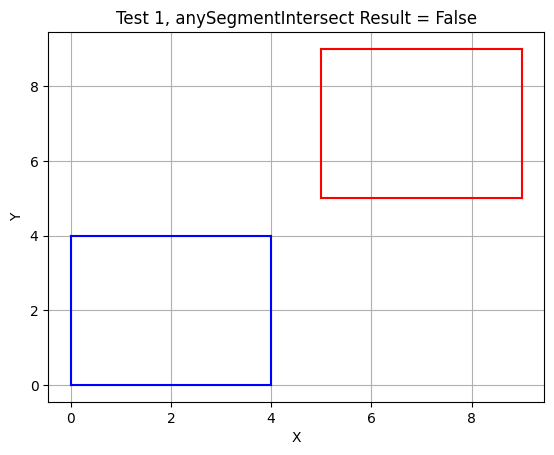

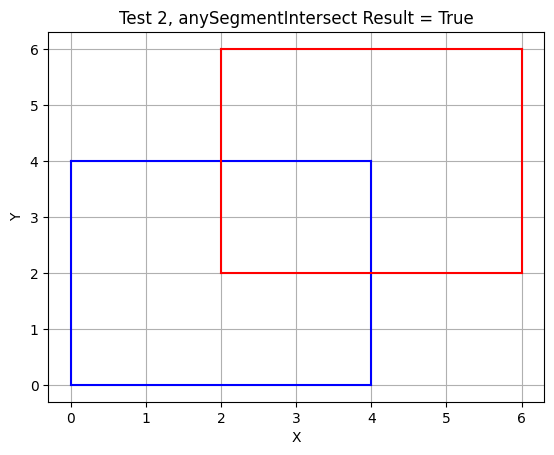

Test 3 failed


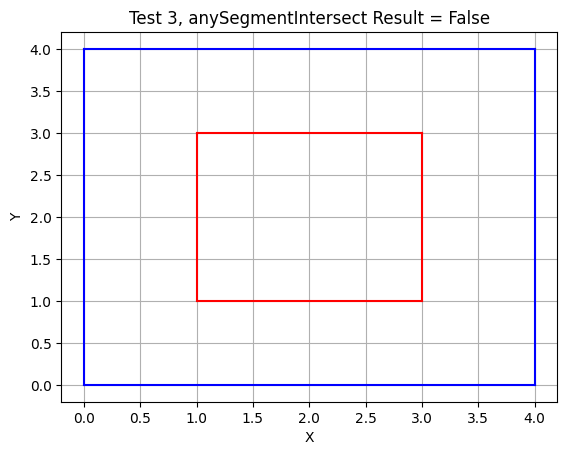

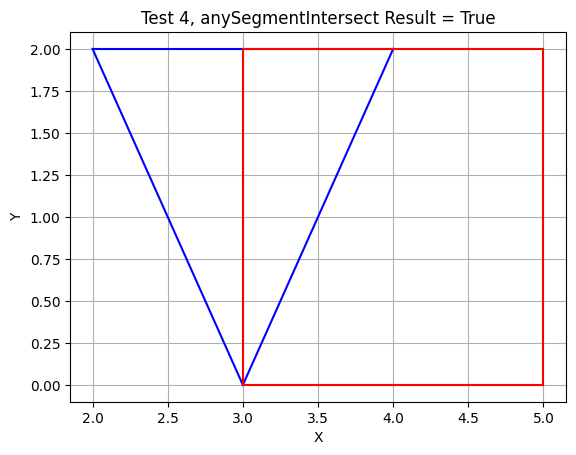

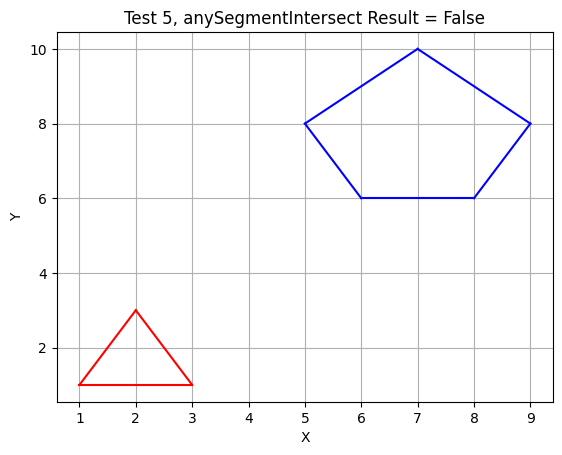

Test 6 failed


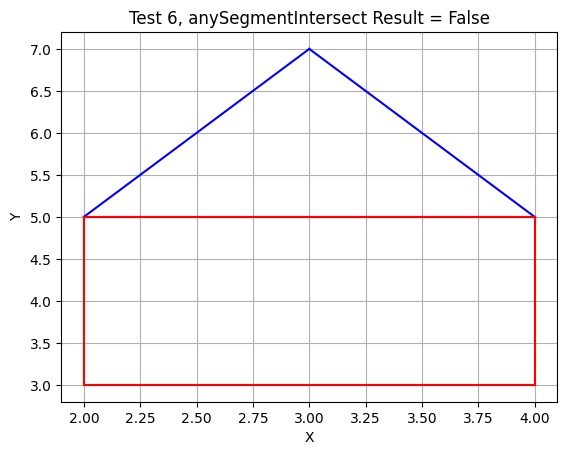

Test 7 failed


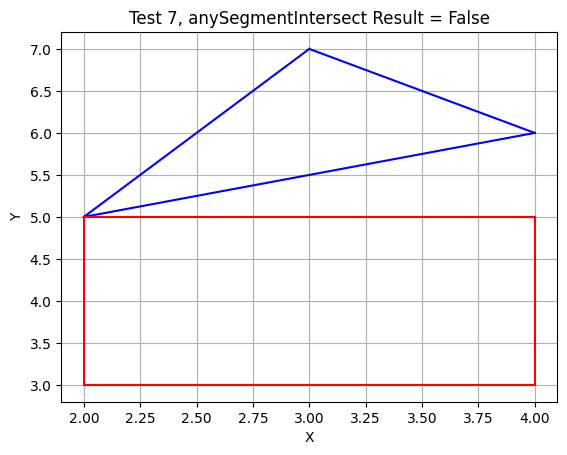

In [14]:
def testAnySegmentsIntersect():
    
    # Test 1: Two squares that don't intersect
    segments1 = [
        Segment(Point(0, 0), Point(4, 0)),
        Segment(Point(4, 0), Point(4, 4)),
        Segment(Point(4, 4), Point(0, 4)),
        Segment(Point(0, 4), Point(0, 0))
    ]

    segments2 = [
        Segment(Point(5, 5), Point(9, 5)),
        Segment(Point(9, 5), Point(9, 9)),
        Segment(Point(9, 9), Point(5, 9)),
        Segment(Point(5, 9), Point(5, 5))
    ]

    resultTest1 = anySegmentIntersect(segments1, segments2)

    if resultTest1:
        print("Test 1 failed")

    plot_segments(segments1, segments2, "Test 1", resultTest1)


    # Test 2: Two overlapping squares
    segments3 = [
        Segment(Point(2, 2), Point(6, 2)),
        Segment(Point(6, 2), Point(6, 6)),
        Segment(Point(6, 6), Point(2, 6)),
        Segment(Point(2, 6), Point(2, 2))
    ]

    resultTest2 = anySegmentIntersect(segments1, segments3)
    
    if not resultTest2:
        print("Test 2 failed")

    plot_segments(segments1, segments3, "Test 2", resultTest2)


    # Test 3: One square inside another
    segments4 = [
        Segment(Point(1, 1), Point(3, 1)),
        Segment(Point(3, 1), Point(3, 3)),
        Segment(Point(3, 3), Point(1, 3)),
        Segment(Point(1, 3), Point(1, 1))
    ]

    resutlTest3 = anySegmentIntersect(segments1, segments4)
    
    if not resutlTest3:
        print("Test 3 failed")

    plot_segments(segments1, segments4, "Test 3", resutlTest3)


    # Test 4: Triangle and square that intersect at a vertex and other places

    segments9 = [
        Segment(Point(2, 2), Point(4, 2)),
        Segment(Point(4, 2), Point(3, 0)),
        Segment(Point(3, 0), Point(2, 2))
    ]

    segments10 = [
        Segment(Point(3, 0), Point(5, 0)),
        Segment(Point(5, 0), Point(5, 2)),
        Segment(Point(5, 2), Point(3, 2)),
        Segment(Point(3, 2), Point(3, 0))
    ]

    resultTest4 = anySegmentIntersect(segments9, segments10)
    
    if not resultTest4:
        print("Test 4 failed")

    plot_segments(segments9, segments10, "Test 4", resultTest4)


    # Test 5: Pentagon and triangle that don't intersect
    segments11 = [
        Segment(Point(6, 6), Point(8, 6)),
        Segment(Point(8, 6), Point(9, 8)),
        Segment(Point(9, 8), Point(7, 10)),
        Segment(Point(7, 10), Point(5, 8)),
        Segment(Point(5, 8), Point(6, 6))
    ]

    segments12 = [
        Segment(Point(1, 1), Point(3, 1)),
        Segment(Point(3, 1), Point(2, 3)),
        Segment(Point(2, 3), Point(1, 1))
    ]

    resultTest5 = anySegmentIntersect(segments11, segments12)
    
    if resultTest5:
        print("Test 5 failed")

    plot_segments(segments11, segments12, "Test 5", resultTest5)


    # Test 6: Triangle and square that intersect at exactly two verteces
    segments13 = [
        Segment(Point(3, 7), Point(2, 5)),
        Segment(Point(2, 5), Point(4, 5)),
        Segment(Point(4, 5), Point(3, 7))
    ]

    segments14 = [
        Segment(Point(2, 5), Point(4, 5)),
        Segment(Point(4, 5), Point(4, 3)),
        Segment(Point(4, 3), Point(2, 3)),
        Segment(Point(2, 3), Point(2, 5))
    ]

    resultTest6 = anySegmentIntersect(segments13, segments14)

    if not resultTest6:
        print("Test 6 failed")

    plot_segments(segments13, segments14, "Test 6", resultTest6)

    # Test 7: Triangle and square that intersect at exactly one vertex
    segments15 = [
        Segment(Point(3, 7), Point(2, 5)),
        Segment(Point(2, 5), Point(4, 6)),
        Segment(Point(4, 6), Point(3, 7))
    ]

    segments16 = [
        Segment(Point(2, 5), Point(4, 5)),
        Segment(Point(4, 5), Point(4, 3)),
        Segment(Point(4, 3), Point(2, 3)),
        Segment(Point(2, 3), Point(2, 5))
    ]

    resultTest7 = anySegmentIntersect(segments15, segments16)

    if not resultTest7:
        print("Test 7 failed")

    plot_segments(segments15, segments16, "Test 7", resultTest7)


testAnySegmentsIntersect()

Veja que o test 6 e 7 tratam do caso em que um triângulo intercepta um quadrado em exatamente 2 e 1 vértices, respectivamente. Veja que o nosso algoritmo de interceptação de segmentos retornou False para ambos os testes, falhando em dizer que houve interceptação nos vértices.

Porém, como havíamos dito anteriormente, isso é exatamente o comportamento que desejávamos pois quando gerarmos a separação linear desses dados, a reta passará exatamente sobre esse ponto (ou pontos).

Por outro lado, o teste 3, que é o teste referente a uma envoltória contida dentro da outra, falhou. Realmente as envoltórias não se interceptam, porém, elas não serão separáveis. Portanto, devemos criar um algoritmo que verifica se duas envoltóris são separáveis e não apenas se elas se interceptam.

# 3. Verificação de separabilidade

Nessa seção iremos descobrir se duas envoltórias são separáveis ou não. Isso é feito com o auxílio da função de varredura linear desenvolvida e discutida na seção anterior. 

O algoritmo de separabilidade irá 

- checar primeiramente se há alguma interseção entre os vértices das duas envoltórias convexas caso houver retornamos False (indica que não são separáveis) 

- caso contrário, iremos testar se uma está contida na outra, considerando a que tem o ponto mais a esquerda a envoltória externa, caso uma estiver contida na outra retornamos False (indica que não são separáveis)

- caso contrário, verificamos se elas são a mesma envoltória, se sim retorna False (indica que não são separáveis)
        
- caso contrário, retorna True (indica que são separáveis)


In [15]:
def isInside(outsideHull:list, insideHull:list) -> bool:
    """
    Check if insideHull is completely inside of outsideHull
    :param outsideHull: list of Segment that represents a convex hull
    :param insideHull: list of Segment that represents a convex hull
    :return: if insideHull is really inside return True otherwise False
    """
    referencePoint = insideHull[0].leftmostPoint()
    for edge in outsideHull:
        if edge.direction(referencePoint) <= 0:
            return False
    return True

def isTheSame(convexHull1, convexHull2):
    """
    Check if convexHull1 is the same as convexHull2
    :param convexHull1: list of Segment that represents a convex hull
    :param convexHull2: list of Segment that represents a convex hull
    :return: if they are the same return True otherwise False
    """
    sortedHull1 = sorted(convexHull1)
    sortedHull2 = sorted(convexHull2)

    if sortedHull1 == sortedHull2:
        return True
    return False

In [16]:
def isSeparable(convexHull1, convexHull2):
    """
    Check if the hulls are separable 
    :param convexHull1: list of Segment that represents a convex hull
    :param convexHull2: list of Segment that represents a convex hull
    :return: if they are separable return True otherwise False   
    """
    if anySegmentIntersect(convexHull1, convexHull2):
        return False
    
    # obtain the left most point of each hull
    minHull1 = min(convexHull1)
    minHull2 = min(convexHull2)

    # the one hull with the left most point is considered the outside hull
    if minHull1 < minHull2 and isInside(convexHull1, convexHull2):
        return False
    if isInside(convexHull2, convexHull1):
        return False
    
    if isTheSame(convexHull1, convexHull2):
        return False
    
    return True

In [17]:
def testIsSeparable():
    # Test 1: Two squares that don't intersect
    segments1 = [
        Segment(Point(0, 0), Point(4, 0)),
        Segment(Point(4, 0), Point(4, 4)),
        Segment(Point(4, 4), Point(0, 4)),
        Segment(Point(0, 4), Point(0, 0))
    ]

    segments2 = [
        Segment(Point(5, 5), Point(9, 5)),
        Segment(Point(9, 5), Point(9, 9)),
        Segment(Point(9, 9), Point(5, 9)),
        Segment(Point(5, 9), Point(5, 5))
    ]

    if not isSeparable(segments1, segments2):
        print("Test 1 failed")


    # Test 2: Two overlapping squares
    segments3 = [
        Segment(Point(2, 2), Point(6, 2)),
        Segment(Point(6, 2), Point(6, 6)),
        Segment(Point(6, 6), Point(2, 6)),
        Segment(Point(2, 6), Point(2, 2))
    ]

    if isSeparable(segments1, segments3):
        print("Test 2 failed")


    # Test 3: One square inside another
    segments4 = [
        Segment(Point(1, 1), Point(3, 1)),
        Segment(Point(3, 1), Point(3, 3)),
        Segment(Point(3, 3), Point(1, 3)),
        Segment(Point(1, 3), Point(1, 1))
    ]

    if isSeparable(segments1, segments4):
        print("Test 3 failed")

    # Test 4: Triangle and square that intersect at a vertex
    segments9 = [
        Segment(Point(2, 2), Point(4, 2)),
        Segment(Point(4, 2), Point(3, 0)),
        Segment(Point(3, 0), Point(2, 2))
    ]

    segments10 = [
        Segment(Point(3, 0), Point(5, 0)),
        Segment(Point(5, 0), Point(5, 2)),
        Segment(Point(5, 2), Point(3, 2)),
        Segment(Point(3, 2), Point(3, 0))
    ]

    if isSeparable(segments9, segments10):
        print("Test 4 failed")


    # Test 5: Pentagon and triangle that don't intersect
    segments11 = [
        Segment(Point(6, 6), Point(8, 6)),
        Segment(Point(8, 6), Point(9, 8)),
        Segment(Point(9, 8), Point(7, 10)),
        Segment(Point(7, 10), Point(5, 8)),
        Segment(Point(5, 8), Point(6, 6))
    ]

    segments12 = [
        Segment(Point(1, 1), Point(3, 1)),
        Segment(Point(3, 1), Point(2, 3)),
        Segment(Point(2, 3), Point(1, 1))
    ]

    if not isSeparable(segments11, segments12):
        print("Test 5 failed")


    # two convex hulls are the same
    if isSeparable(segments11, segments11):
        print("Test 6 failed")    

testIsSeparable()

Sabendo que as envoltórias podem se divididas devemos encontrar o par de pontos mais proximos das envoltórias

In [18]:
def getClosestPoint(convexHull1:list, convexHull2:list) -> tuple:
    pointsHull1 = [s.origin for s in convexHull1]
    pointsHull2 = [s.origin for s in convexHull2]

    dist = float('inf')
    for point1 in pointsHull1:
        for point2 in pointsHull2:
            tempDist = point1.distance(point2)
            if tempDist < dist:
                closestPoints = (point1, point2)
                dist = tempDist
            
    return closestPoints

In [19]:
def testClosestPoint():
    segments1 = [
        Segment(Point(0, 0), Point(4, 0)),
        Segment(Point(4, 0), Point(4, 4)),
        Segment(Point(4, 4), Point(0, 4)),
        Segment(Point(0, 4), Point(0, 0))
    ]

    segments2 = [
        Segment(Point(5, 5), Point(9, 5)),
        Segment(Point(9, 5), Point(9, 9)),
        Segment(Point(9, 9), Point(5, 9)),
        Segment(Point(5, 9), Point(5, 5))
    ]

    p0, p1 = getClosestPoint(segments1, segments2)
    assert p0.distance(p1) == (2)**(1/2), print("Test 1 failed")

    segments3 = [
        Segment(Point(6, 6), Point(8, 6)),
        Segment(Point(8, 6), Point(9, 8)),
        Segment(Point(9, 8), Point(7, 10)),
        Segment(Point(7, 10), Point(5, 8)),
        Segment(Point(5, 8), Point(6, 6))
    ]

    segments4 = [
        Segment(Point(1, 1), Point(3, 1)),
        Segment(Point(3, 1), Point(2, 3)),
        Segment(Point(2, 3), Point(1, 1))
    ]

    p3, p4 = getClosestPoint(segments3, segments4)
    assert p3.distance(p4) == 5, print("Test 2 failed")

    segments5 = [
        Segment(Point(0, 0), Point(1, 0)),
        Segment(Point(1, 0), Point(1, 1)),
        Segment(Point(1, 1), Point(0, 1)),
        Segment(Point(0, 1), Point(0, 0))
    ]

    segments6 = [
        Segment(Point(0, 2), Point(1, 2)),
        Segment(Point(1, 2), Point(1, 3)),
        Segment(Point(1, 3), Point(0, 3)),
        Segment(Point(0, 3), Point(0, 2))
    ]

    p5, p6 = getClosestPoint(segments5, segments6)
    assert p5.distance(p6) == 1, print("Test 3 failed")

testClosestPoint()

Sabendo os dois pontos mais próximos podemos calcular a reta perpendicular ao ponto médio deles. A função a baixo retorna uma função que aceita uma coordenada x e retorna o ponto equivalente na reta perpendicular ao ponto médio.

In [20]:
def generateLine(p0, p1):
    middlePoint = Point((p0.x + p1.x)/2, (p0.y + p1.y)/2)

    a = - (p1.x - p0.x)/(p1.y - p0.y)
    b = middlePoint.y - a * middlePoint.x

    return lambda x: a * x + b

In [21]:
def testGenerateLine():
    point1 = Point(4, 4)
    point2 = Point(4, 6)

    f1 = generateLine(point1, point2)
    assert f1(4) == 5, print("Test 1 failed")


    point3 = Point(1, 4)
    point4 = Point(7, 2)

    f2 = generateLine(point3, point4)
    assert f2(3) == 0, print("Test 2 failed")


    point5 = Point(1, 4)
    point6 = Point(3, -2)

    f3 = generateLine(point5, point6)
    assert f3(5) == 2, print("Test 3 failed")

testGenerateLine()

# 4. Construção do modelo e classificador

In [28]:
def classify(groupA, groupB, groupTest):
    """
    Essa função faz o processo de classificação, montando a envoltoria, checando a separabilidade e classificando no final
    :param groupA: Lista de pontos dos elementos de A
    :param groupB: Lista de pontos dos elementos de A
    :param groupTest: Lista de pontos dos elementos sem classificação
    :return: uma lista com True, False ou -1
        True -> indica que o ponto pertence ao grupo A
        False -> indica que o ponto não pertence ao grupo A
        -1 -> indica que o ponto se encontra na mediatriz, portanto não pode ser classificado
    """    
    hullA = giftWrapping(groupA)
    hullB = giftWrapping(groupB)

    lenA = len(hullA)
    lenB = len(hullB)

    hullA = [Segment(hullA[i], hullA[(i+1)%lenA]) for i in range(lenA)]
    hullB = [Segment(hullB[i], hullB[(i+1)%lenB]) for i in range(lenB)]

    if not isSeparable(hullA, hullB):
        print("Grupos não são separáveis")
        return []
    
    closestPointA, closestPointB = getClosestPoint(hullA, hullB)
    classifier = generateLine(closestPointA, closestPointB)

    y = classifier(closestPointA.x)
    if closestPointA.y < y:
        isA = True
    elif closestPointA.y > y:
        isA = False

    classified = []

    for point in groupTest:
        y = classifier(point.x)
        if point.y < y:
            classified.append(isA)
        elif point.y > y:
            classified.append(not isA)
        else:
            classified.append(-1)

    return classified

In [29]:
def testClassify():
    pointsA = [
        Point(0, 0),
        Point(4, 0),
        Point(0, 4),
        Point(4, 4)
    ]

    pointsB = [
        Point(5, 5),
        Point(5, 9),
        Point(9, 5),
        Point(9, 9)
    ]

    pointsTest = [
        Point(1, 1),
        Point(-1, 11),
        Point(6, 6),
        Point(9, -1),
        Point(9, 0),
    ]

    assert classify(pointsA, pointsB, pointsTest) == [True, False, False, True, -1], print("Test 1 failed")
    assert classify(pointsB, pointsA, pointsTest) == [False, True, True, False, -1], print("Test 2 failed")

testClassify()

# 5. Método para computação das métricas

# 6. Conclusão dos experimentos

# 7. Conclusão do relatório